# Are we consuming more local?

## Research questions

1. Where are the products we consume in our everyday life coming from?

    - Which countries produce the primary resources (ground ingredients) consumed in Switzerland?
    - Which countries manufacture most of the products consumed in Switzerland?


2. Is there a trend over time to consume more local products?

    - Are new products mostly using primary resources from Switzerland? Or from other countries inside Europe?
    - Are new products mostly manufactured in Switzerland? Or from other countries inside Europe?
    - Is there a trend over time to local products to promote their origin?

## Datasets

Open Food Facts (https://world.openfoodfacts.org/data)

Additional datasets “Evolution de la consommation de denrées alimentaires en Suisse” (https://opendata.swiss/fr/dataset/entwicklung-des-nahrungsmittelverbrauches-in-der-schweiz-je-kopf-und-jahr1) and “Dépenses fédérales pour l’agriculture et l’alimentation” (https://opendata.swiss/fr/dataset/bundesausgaben-fur-die-landwirtschaft-und-die-ernahrung1) from https://opendata.swiss/fr/group/agriculture

A last additional dataset for the second question of the project
https://www.gate.ezv.admin.ch/swissimpex/public/bereiche/waren/result.xhtml
Total of imports of agriculture, forestry and fishing goods

## TODO

   - Cleaning/Exploring dataset
   - Descriptive analysis
   - We should determine the list of products that are sold in Switzerland
   - We should then classify these products under different categories:
        - products entirely originating from Switzerland
        - products partially originating from Switzerland (manufactured in Switzerland but ingredients are from another country)
        - products not originating from Switzerland
   - Draw statistics from the importation balances, determining which are the countries producing most of the ground ingredients and manufacturing the products consumed in Switzerland.


In [1]:
#imports
import re
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt

import findspark
findspark.init()
import pyspark

from functools import reduce
from pyspark.sql import *
from pyspark.sql import functions as F
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark.sql.functions import min
from pyspark.sql.functions import to_date, last_day,date_add
from datetime import timedelta

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [2]:
DATA_FOLDER = 'data'

# Loading data

## Open Food Fact data

General information about columns of OpenFoodFact dataset are available on:

https://static.openfoodfacts.org/data/data-fields.txt

__General information__
- __code__: barcode of the product (can be EAN-13 or internal codes for some food stores), for products without a barcode, Open Food Facts assigns a number starting with the 200 reserved prefix
- __product_name__: name of the product

__Geo information__
- __origins__: origins of ingredients
- __manufacturing_places__: places where manufactured or transformed
- __countries__: list of countries where the product is sold


In [39]:
dataset_main = spark.read.csv(DATA_FOLDER+"/en.openfoodfacts.org.products.csv", header=True, mode="DROPMALFORMED", sep = '\t')

dataset_main.createOrReplaceTempView("data_main")

# Filter required columns
p_id_col = " code, product_name, "
general_cols = " brands, brands_tags, categories, categories_tags, origins, origins_tags, manufacturing_places, manufacturing_places_tags,labels,labels_tags,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags "
geo_cols = " origins, manufacturing_places, countries "
geo_tags_cols = " origins_tags, manufacturing_places_tags, countries_tags "

off_df = spark.sql("SELECT" + p_id_col + geo_cols + " FROM data_main")
off_df.printSchema()

root
 |-- code: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- origins: string (nullable = true)
 |-- manufacturing_places: string (nullable = true)
 |-- countries: string (nullable = true)



In [40]:
off_all_size = off_df.count()
off_cols_size = len(off_df.columns)
print("All data Size:\n" + str(off_cols_size) + "(columns) * " + str(off_all_size) + "(rows)")

All data Size:
5(columns) * 693829(rows)


### Data Cleaning and Preprocessing

In [41]:
# Find number of missing data

off_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in off_df.columns]).show()

+----+------------+-------+--------------------+---------+
|code|product_name|origins|manufacturing_places|countries|
+----+------------+-------+--------------------+---------+
|   0|       25982| 651635|              626848|      561|
+----+------------+-------+--------------------+---------+



In [42]:
off_df.createOrReplaceTempView("off_df")

sql_filter = "SELECT * FROM off_df WHERE countries is not NULL AND manufacturing_places is not NULL AND origins is not NULL"

# off_p_df = off_df.where((off_df.countries.isNotNull()) & (off_df.manufacturing_places.isNotNull()) & (off_df.origins.isNotNull()) ).show()
off_p_df = spark.sql(sql_filter)
off_p_all_size = off_p_df.count()
off_p_cols_size = len(off_p_df.columns)
print("Full GEO information data Size:\n" + str(off_p_cols_size) + "(columns) * " + str(off_p_all_size) + "(rows)")

Full GEO information data Size:
5(columns) * 26986(rows)


In [44]:
off_p_df.show(10)

+-------------+--------------------+-------------+--------------------+--------------+
|         code|        product_name|      origins|manufacturing_places|     countries|
+-------------+--------------------+-------------+--------------------+--------------+
|0000000274722|Blanquette de Vol...|       France|              France|        France|
|0000000290616|        Salade Cesar|       Québec|     Brossard Québec|        Canada|
|0000000394710|Danoises à la can...|       Québec|     Brossard Québec|        Canada|
|0000001071894|               Flute|       France|      United Kingdom|United Kingdom|
|0000001938067|Chaussons tressés...|       Québec|     Brossard Québec|        Canada|
|0000004302544| Pain Burger Artisan|       Québec|     Brossard,Québec|        Canada|
|0000008237798|     Quiche Lorraine|       Québec|     Brossard,Québec|        Canada|
|0000008240095|      Pâté au poulet|       Québec|     Brossard Québec|        Canada|
|0000012167005|Brioches roulées ...|Québec,

In [45]:
#create a specific filter for Swiss occurences

filter_ch = '[Ss]witzerland|[Ss]uisse|[Ss]chweiz|[Ss]vizerra'

In [49]:
#store products that are sold in Switzerland
swiss_sold_data = off_p_df.filter(off_p_df["countries"].rlike(filter_ch))

swiss_sold_size = swiss_sold_data.count()
print("swiss_sold data Size:\n" + str(swiss_sold_size))

swiss_sold data Size:
762


In [50]:
#store products which ingredients originate from Switzerland
swiss_origin_data = off_p_df.filter(off_p_df["origins"].rlike(filter_ch))

swiss_origin_size = swiss_origin_data.count()
print("swiss_origin data Size:\n" + str(swiss_origin_size))

swiss_origin data Size:
482


In [51]:
#store products that are manufactured in Switzerland
swiss_manu_data = off_p_df.filter(off_p_df["manufacturing_places"].rlike(filter_ch))

swiss_manu_size = swiss_manu_data.count()
print("swiss_manufactored data Size:\n" + str(swiss_manu_size))

swiss_manufactored data Size:
545


In [52]:
#store products that are both manufactured and originate from Switzerland
swiss_origin_manu_data = off_p_df.filter(off_p_df["origins"].rlike(filter_ch) & off_p_df["manufacturing_places"].rlike(filter_ch))

swiss_origin_manu_size = swiss_origin_manu_data.count()
print("swiss_origin_manufactored data Size:\n" + str(swiss_origin_manu_size))

swiss_origin_manufactored data Size:
379


In [53]:
######## DATA PREPARATION FOR PIE ########
#
#count products whose ingredients from switzerland but which were not manufactured in Switzerland
swiss_origin_tot = swiss_origin_data.filter(~ swiss_origin_data["manufacturing_places"].rlike(filter_ch)).count()

#Total of products sold in Switzerland
swiss_sold_tot = swiss_sold_data.count()

#count products that do not have swiss ingredients
swiss_manu_tot = swiss_manu_data.filter(~ swiss_manu_data["origins"].rlike(filter_ch)).count()
#products that are sold in Switzerland but that were not manufactured in CH and that do not have swiss ingredients
non_swiss_sold_tot = swiss_sold_data.filter(~ swiss_sold_data["manufacturing_places"].rlike(filter_ch) & ~swiss_sold_data["origins"].rlike(filter_ch)).count()
#total of products that are both manufactured and has ingredients from Switzerland
swiss_origin_manu_tot = swiss_origin_manu_data.count()

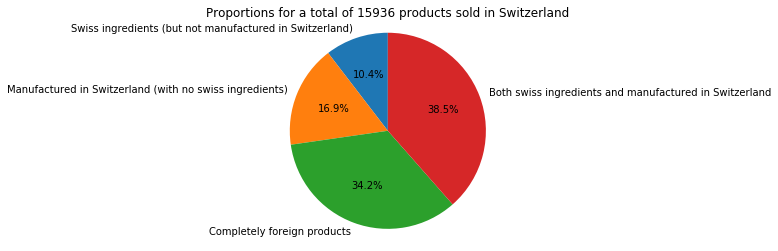

In [12]:
labels = 'Swiss ingredients (but not manufactured in Switzerland)', 'Manufactured in Switzerland (with no swiss ingredients)', 'Completely foreign products', 'Both swiss ingredients and manufactured in Switzerland'
sizes = [swiss_origin_tot, swiss_manu_tot, non_swiss_sold_tot, swiss_origin_manu_tot]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Proportions for a total of ' + str(swiss_sold_tot) + ' products sold in Switzerland')

plt.show()

In [64]:
#About foreign products
#Store products that are neither manufactured nor have ingredients from Switzerland
non_swiss_sold = swiss_sold_data.filter(~ swiss_sold_data["manufacturing_places"].rlike(filter_ch) & ~swiss_sold_data["origins"].rlike(filter_ch))

non_swiss_sold_size = non_swiss_sold.count()
print("Non swiss/Sold in Switzerland data Size:\n" + str(non_swiss_sold_size))

Non swiss/Sold in Switzerland data Size:
342


In [58]:
# store products that are sold in Switzerland but ingredients are from foreign places
non_swiss_ing_sold = off_p_df.filter(off_p_df.countries.rlike(filter_ch) & ~off_p_df.origins.rlike(filter_ch))

print("swiss_manufactored data Size:\n" + str(non_swiss_ing_sold.count()))

swiss_manufactored data Size:
410


In [60]:
non_swiss_ing_sold.show(10)

+--------+--------------------+--------------------+--------------------+--------------------+
|    code|        product_name|             origins|manufacturing_places|           countries|
+--------+--------------------+--------------------+--------------------+--------------------+
|00152297|  Mélange  randonnée|         indéterminé|              Suisse|       en:IT, Suisse|
|20002183| Körniger Frischkäse|           Allemagne|Privatmolkerei Be...|Tyskland,Sverige,...|
|20021030|Le Jambon Supérie...|    Union Européenne|LAMPAULAISE DES S...|France, en:switze...|
|20052713|Amandes de Califo...|      Californie,USA|Allemagne,Deutsch...|en:france, en:ger...|
|20177492|         Maple Syrup|              Canada|              Canada|France,Espagne,Su...|
|20201920|        Oriental Mix|fr:Cacahuètes d'A...|            Pays-Bas|en:france, en:aus...|
|20240394|Poitrine de poule...|              Brésil|              Suisse|              Suisse|
|20283360| Haferflocken, grove|         Scandinavi

In [66]:
# Find dominant importers of ingredients
non_swiss_sold.createOrReplaceTempView("target_products_df")
target_origins = spark.sql("SELECT origins, COUNT(origins) FROM target_products_df GROUP BY origins ORDER BY COUNT(origins) DESC")
target_origins.show()

# TODO: target_origins may contain repetitive countries (using two different names for one country)
print("Number of ingredient importers:\n" + str(target_origins.count()))

+--------------------+--------------+
|             origins|count(origins)|
+--------------------+--------------+
|              France|            77|
|              Italie|            34|
|    Union Européenne|            10|
|           Allemagne|             6|
|            Pays-Bas|             5|
|         Deutschland|             4|
|     Océan Pacifique|             4|
|             Espagne|             4|
|             Vietnam|             4|
|           Thaïlande|             3|
|               Grèce|             3|
|         Lait,France|             3|
|        Océan Indien|             3|
|             Italien|             3|
|Viande de Porc,Un...|             3|
|               Italy|             3|
|               Chine|             3|
|    Union européenne|             2|
|             Mexique|             2|
|               Pérou|             2|
+--------------------+--------------+
only showing top 20 rows

Number of ingredient importers:
173


In [67]:
# Find dominant importers (manufacturers)
non_swiss_sold.createOrReplaceTempView("target_products_df")
target_manufacturers = spark.sql("SELECT manufacturing_places, COUNT(manufacturing_places) FROM target_products_df GROUP BY manufacturing_places ORDER BY COUNT(manufacturing_places) DESC")
target_manufacturers.show()

# TODO: target_manufacturers may contain repetitive countries (using two different names for one country)
print("Number of Manufacturers:\n" + str(target_manufacturers.count()))

+--------------------+---------------------------+
|manufacturing_places|count(manufacturing_places)|
+--------------------+---------------------------+
|              France|                         70|
|              Italie|                         35|
|           Allemagne|                         26|
|         Deutschland|                          8|
|            Pays-Bas|                          6|
|           Thaïlande|                          5|
|Herta SAS - Route...|                          3|
|             Espagne|                          3|
|             Italien|                          3|
|            Danemark|                          3|
|          Angleterre|                          2|
|             Germany|                          2|
|Triballat Noyal -...|                          2|
|Châteaubourg,Renn...|                          2|
|Fromageries des C...|                          2|
|              france|                          2|
|             Mexique|         

### Working with products' traces

In [69]:
extra_info_df = ' traces '
traces_df = spark.sql("SELECT" + p_id_col + extra_info_df + " FROM data_main")
traces_df.show(10)

+-------------+--------------------+------+
|         code|        product_name|traces|
+-------------+--------------------+------+
|0000000000017|    Vitória crackers|  null|
|0000000000031|               Cacao|  null|
|0000000000123|Sauce Sweety chil...|  null|
|0000000000291|           Mendiants|  null|
|0000000000949|Salade de carotte...|  null|
|0000000000970|Fromage blanc aux...|  null|
|0000000001001|                null|  null|
|0000000001007|            Vainilla|  null|
|0000000001137|   Baguette parisien|  null|
|0000000001151|&quot;Baguette Ly...|  null|
+-------------+--------------------+------+
only showing top 10 rows



In [70]:
traces_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in traces_df.columns]).show()

+----+------------+------+
|code|product_name|traces|
+----+------------+------+
|   0|       25982|646811|
+----+------------+------+



In [78]:
non_swiss_sold.createOrReplaceTempView("target_products_df")
traces_df.createOrReplaceTempView("traces_df")
joined_df = spark.sql("SELECT p.code, t.traces, p.origins, p.manufacturing_places, p.countries  FROM target_products_df p INNER JOIN traces_df t ON p.code = t.code")

In [79]:
joined_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in joined_df.columns]).show()

+----+------+-------+--------------------+---------+
|code|traces|origins|manufacturing_places|countries|
+----+------+-------+--------------------+---------+
|   0|   254|      0|                   0|        0|
+----+------+-------+--------------------+---------+



In [81]:
joined_df.createOrReplaceTempView("target_products_traces")
sql_filter = "SELECT * FROM target_products_traces WHERE traces is not NULL"
target_products_traces_p = spark.sql(sql_filter)

print("Number of Products sold in Switzerland with traces:\n" + str(target_products_traces_p.count()))

Number of Products sold in Switzerland with traces:
88


In [86]:
# Flatten traces column
target_products_traces_p = target_products_traces_p.withColumn('traces', F.explode_outer(F.split('traces', ',')))

# Remove occurances of en: in name of traces
target_products_traces_p = target_products_traces_p.withColumn('traces', F.regexp_replace('traces', 'en:', ''))

target_products_traces_p.show()

+-------------+--------------------+--------------------+--------------------+--------------------+
|         code|              traces|             origins|manufacturing_places|           countries|
+-------------+--------------------+--------------------+--------------------+--------------------+
|4104420209114|                nuts|Agriculture UE/No...|            Pays-Bas|    Allemagne,Suisse|
|3256540011465|                nuts|              France|              France|       France,Suisse|
|3256540011465|             peanuts|              France|              France|       France,Suisse|
|4104420057227|            Erdnüsse|Nicht-EU-Landwirt...|              Ungarn|Österreich,Frankr...|
|4104420057227|               Milch|Nicht-EU-Landwirt...|              Ungarn|Österreich,Frankr...|
|3276770006208|              Céleri|Pérou,Mexique,Rus...|              France|       France,Suisse|
|3276770006208|              Gluten|Pérou,Mexique,Rus...|              France|       France,Suisse|


In [87]:
# Find dominant importers of ingredients
target_products_traces_p.createOrReplaceTempView("target_products_traces_p")
target_traces = spark.sql("SELECT traces, COUNT(traces) FROM target_products_traces_p GROUP BY traces ORDER BY COUNT(traces) DESC")
target_traces.show()

# TODO: target_traces may contain repetitive traces (using two different names for one trace)
print("Number of traces:\n" + str(target_traces.count()))

+-----------------+-------------+
|           traces|count(traces)|
+-----------------+-------------+
|   Fruits à coque|           25|
|             nuts|           13|
|             Soja|           11|
|           Gluten|           11|
|             Œufs|           11|
|           Céleri|            8|
|         soybeans|            7|
|           gluten|            7|
|Graines de sésame|            7|
|         Moutarde|            7|
|        Arachides|            6|
|             milk|            6|
|          peanuts|            6|
|             Lait|            6|
|             eggs|            5|
|        Crustacés|            5|
|            Milch|            4|
|          Poisson|            4|
|       Mollusques|            3|
|     sesame-seeds|            3|
+-----------------+-------------+
only showing top 20 rows

Number of traces:
95


In [ ]:
# TODO: Group importers by traces

In [14]:
#cleaning up the different foreign countries to better count them
non_swiss_sold = non_swiss_sold.withColumn('origins', F.explode_outer(F.split('origins', ',')))
non_swiss_sold = non_swiss_sold.withColumn('origins', F.regexp_replace('origins', ',|\\?', ''))

In [15]:
#Import dataset country from http://download.geonames.org/export/dump/
dataset_country_names = spark.read.option("header", "false") \
    .option("delimiter", '\t') \
    .option("inferSchema", "true") \
    .csv(DATA_FOLDER+"/allCountries.txt")

In [16]:
#Import all the alternativeNames from the dataset http://download.geonames.org/export/dump/ 
dataset_alt_names = spark.read.option("header", "false") \
    .option("delimiter", '\t') \
    .option("inferSchema", "true") \
    .csv(DATA_FOLDER+"/alternateNames.txt")

In [17]:
#Arrange the dataset with correct column names (the dataset is under the form of a txt file with no header)
#Header names are directly retrieved from the siteweb explanations
oldColumns = dataset_country_names.schema.names
newColumns = ["geonameid", "name", "asciiname","alternatenames","latitude","longitude","feature_class", "feature_code", "country_code","cc2","admin1_code","admin2_code","admin3_code","admin4_code","population","elevation","dem","timezone","modification_date"]

dataset_country_names = reduce(lambda dataset_country_names, idx: dataset_country_names.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), dataset_country_names)
dataset_country_names.printSchema()
dataset_country_names.show(2)

root
 |-- geonameid: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- asciiname: string (nullable = true)
 |-- alternatenames: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- feature_class: string (nullable = true)
 |-- feature_code: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- cc2: string (nullable = true)
 |-- admin1_code: string (nullable = true)
 |-- admin2_code: string (nullable = true)
 |-- admin3_code: string (nullable = true)
 |-- admin4_code: string (nullable = true)
 |-- population: long (nullable = true)
 |-- elevation: integer (nullable = true)
 |-- dem: integer (nullable = true)
 |-- timezone: string (nullable = true)
 |-- modification_date: timestamp (nullable = true)

+---------+------------------+------------------+--------------------+--------+---------+-------------+------------+------------+-----+-----------+-----------+-----------+-----------+----------+----

In [18]:
#Arrange the dataset with correct column names (the dataset is under the form of a txt file with no header)
#Header names are directly retrieved from the siteweb explanations
oldColumns = dataset_alt_names.schema.names
newColumns = ["alternateNameId", "geonameid", "isolanguage","alternate_name","isPreferredName","isShortName","isColloquial", "isHistoric", "from","to"]

dataset_alt_names = reduce(lambda dataset_alt_names, idx: dataset_alt_names.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), dataset_alt_names)
dataset_alt_names.printSchema()
dataset_alt_names.show(2)

root
 |-- alternateNameId: integer (nullable = true)
 |-- geonameid: integer (nullable = true)
 |-- isolanguage: string (nullable = true)
 |-- alternate_name: string (nullable = true)
 |-- isPreferredName: integer (nullable = true)
 |-- isShortName: integer (nullable = true)
 |-- isColloquial: integer (nullable = true)
 |-- isHistoric: integer (nullable = true)

+---------------+---------+-----------+------------------+---------------+-----------+------------+----------+
|alternateNameId|geonameid|isolanguage|    alternate_name|isPreferredName|isShortName|isColloquial|isHistoric|
+---------------+---------+-----------+------------------+---------------+-----------+------------+----------+
|        1282063|  2986043|       null|       Pic du Port|           null|       null|        null|      null|
|        4274490|  2986043|       null|Pic de Font Blanca|           null|       null|        null|      null|
+---------------+---------+-----------+------------------+---------------+------

In [19]:
#Create temporary View for SQL work
dataset_country_names.createOrReplaceTempView("country_names")
dataset_alt_names.createOrReplaceTempView("alter_names")

In [38]:
#Cleaning the data country names for origins and manufacturing places
non_swiss_sold.createOrReplaceTempView("non_swiss_data")
non_swiss_renamed = spark.sql("SELECT d1.*, alter_names.geonameid AS origins_geonameid FROM non_swiss_data d1 INNER JOIN alter_names ON alter_names.alternateNameId = (SELECT alternateNameId FROM alter_names WHERE d1.origins LIKE alter_names.alternate_name LIMIT 1)")

#non_swiss_renamed = spark.sql("SELECT d1.*, alter_name_id.geonameid AS origins_geonameid FROM non_swiss_data d1 CROSS APPLY (SELECT TOP 1 d2.geonameid FROM alter_names d2 WHERE d1.origins LIKE d2.alternate_name) alter_name_id")



AnalysisException: "Table or view not found: `alter_names`; line 1 pos 164;\n'Project [ArrayBuffer(d1).*, 'alter_names.geonameid AS origins_geonameid#1639]\n+- 'Join Inner, (alternateNameId#1094 = scalar-subquery#1638 [])\n   :  +- 'GlobalLimit 1\n   :     +- 'LocalLimit 1\n   :        +- 'Project ['alternateNameId]\n   :           +- 'Filter 'd1.origins LIKE 'alter_names.alternate_name\n   :              +- 'UnresolvedRelation `alter_names`\n   :- SubqueryAlias d1\n   :  +- SubqueryAlias non_swiss_data\n   :     +- Project [product_name#17, brands#22, brands_tags#23, categories#24, categories_tags#25, regexp_replace(origins#520, ,|\\?, ) AS origins#541, origins_tags#28, manufacturing_places#29, manufacturing_places_tags#30, labels#31, labels_tags#32, emb_codes#34, emb_codes_tags#35, first_packaging_code_geo#36, cities#37, cities_tags#38, purchase_places#39, stores#40, countries#41, countries_tags#42]\n   :        +- Project [product_name#17, brands#22, brands_tags#23, categories#24, categories_tags#25, origins#520, origins_tags#28, manufacturing_places#29, manufacturing_places_tags#30, labels#31, labels_tags#32, emb_codes#34, emb_codes_tags#35, first_packaging_code_geo#36, cities#37, cities_tags#38, purchase_places#39, stores#40, countries#41, countries_tags#42]\n   :           +- Generate explode(split(origins#27, ,)), true, [origins#520]\n   :              +- Filter (NOT manufacturing_places#29 RLIKE [Ss]witzerland|[Ss]uisse|[Ss]chweiz|[Ss]vizerra && NOT origins#27 RLIKE [Ss]witzerland|[Ss]uisse|[Ss]chweiz|[Ss]vizerra)\n   :                 +- Filter countries#41 RLIKE [Ss]witzerland|[Ss]uisse|[Ss]chweiz|[Ss]vizerra\n   :                    +- Project [product_name#17, brands#22, brands_tags#23, categories#24, categories_tags#25, origins#27, origins_tags#28, manufacturing_places#29, manufacturing_places_tags#30, labels#31, labels_tags#32, emb_codes#34, emb_codes_tags#35, first_packaging_code_geo#36, cities#37, cities_tags#38, purchase_places#39, stores#40, countries#41, countries_tags#42]\n   :                       +- SubqueryAlias data_main\n   :                          +- Relation[code#10,url#11,creator#12,created_t#13,created_datetime#14,last_modified_t#15,last_modified_datetime#16,product_name#17,generic_name#18,quantity#19,packaging#20,packaging_tags#21,brands#22,brands_tags#23,categories#24,categories_tags#25,categories_en#26,origins#27,origins_tags#28,manufacturing_places#29,manufacturing_places_tags#30,labels#31,labels_tags#32,labels_en#33,... 149 more fields] csv\n   +- SubqueryAlias alter_names\n      +- Project [alternateNameId#1094, geonameid#1103, isolanguage#1112, alternate_name#1121, isPreferredName#1130, isShortName#1139, isColloquial#1148, _c7#627 AS isHistoric#1157]\n         +- Project [alternateNameId#1094, geonameid#1103, isolanguage#1112, alternate_name#1121, isPreferredName#1130, isShortName#1139, _c6#626 AS isColloquial#1148, _c7#627]\n            +- Project [alternateNameId#1094, geonameid#1103, isolanguage#1112, alternate_name#1121, isPreferredName#1130, _c5#625 AS isShortName#1139, _c6#626, _c7#627]\n               +- Project [alternateNameId#1094, geonameid#1103, isolanguage#1112, alternate_name#1121, _c4#624 AS isPreferredName#1130, _c5#625, _c6#626, _c7#627]\n                  +- Project [alternateNameId#1094, geonameid#1103, isolanguage#1112, _c3#623 AS alternate_name#1121, _c4#624, _c5#625, _c6#626, _c7#627]\n                     +- Project [alternateNameId#1094, geonameid#1103, _c2#622 AS isolanguage#1112, _c3#623, _c4#624, _c5#625, _c6#626, _c7#627]\n                        +- Project [alternateNameId#1094, _c1#621 AS geonameid#1103, _c2#622, _c3#623, _c4#624, _c5#625, _c6#626, _c7#627]\n                           +- Project [_c0#620 AS alternateNameId#1094, _c1#621, _c2#622, _c3#623, _c4#624, _c5#625, _c6#626, _c7#627]\n                              +- Relation[_c0#620,_c1#621,_c2#622,_c3#623,_c4#624,_c5#625,_c6#626,_c7#627] csv\n"

In [34]:
non_swiss_renamed.show()

AnalysisException: 'Detected implicit cartesian product for INNER join between logical plans\nProject [product_name#17, brands#22, brands_tags#23, categories#24, categories_tags#25, regexp_replace(origins#520, ,|\\?, ) AS origins#541, origins_tags#28, manufacturing_places#29, manufacturing_places_tags#30, labels#31, labels_tags#32, emb_codes#34, emb_codes_tags#35, first_packaging_code_geo#36, cities#37, cities_tags#38, purchase_places#39, stores#40, countries#41, countries_tags#42]\n+- Generate explode(split(origins#27, ,)), [5], true, [origins#520]\n   +- Project [product_name#17, brands#22, brands_tags#23, categories#24, categories_tags#25, origins#27, origins_tags#28, manufacturing_places#29, manufacturing_places_tags#30, labels#31, labels_tags#32, emb_codes#34, emb_codes_tags#35, first_packaging_code_geo#36, cities#37, cities_tags#38, purchase_places#39, stores#40, countries#41, countries_tags#42]\n      +- Filter (((isnotnull(origins#27) && isnotnull(countries#41)) && isnotnull(manufacturing_places#29)) && (countries#41 RLIKE [Ss]witzerland|[Ss]uisse|[Ss]chweiz|[Ss]vizerra && (NOT manufacturing_places#29 RLIKE [Ss]witzerland|[Ss]uisse|[Ss]chweiz|[Ss]vizerra && NOT origins#27 RLIKE [Ss]witzerland|[Ss]uisse|[Ss]chweiz|[Ss]vizerra)))\n         +- Relation[code#10,url#11,creator#12,created_t#13,created_datetime#14,last_modified_t#15,last_modified_datetime#16,product_name#17,generic_name#18,quantity#19,packaging#20,packaging_tags#21,brands#22,brands_tags#23,categories#24,categories_tags#25,categories_en#26,origins#27,origins_tags#28,manufacturing_places#29,manufacturing_places_tags#30,labels#31,labels_tags#32,labels_en#33,... 149 more fields] csv\nand\nFilter isnotnull(Id#1475)\n+- GlobalLimit 1\n   +- LocalLimit 1\n      +- Project [alternateNameId#1094 AS Id#1475]\n         +- Join Inner, origins#541 LIKE alternate_name#1121\n            :- Project [_c0#620 AS alternateNameId#1094, _c3#623 AS alternate_name#1121]\n            :  +- Filter isnotnull(_c3#623)\n            :     +- Relation[_c0#620,_c1#621,_c2#622,_c3#623,_c4#624,_c5#625,_c6#626,_c7#627] csv\n            +- Project [regexp_replace(origins#520, ,|\\?, ) AS origins#541]\n               +- Filter isnotnull(regexp_replace(origins#520, ,|\\?, ))\n                  +- Generate explode(split(origins#27, ,)), [0], true, [origins#520]\n                     +- Project [origins#27]\n                        +- Filter (((isnotnull(origins#27) && isnotnull(countries#41)) && isnotnull(manufacturing_places#29)) && (countries#41 RLIKE [Ss]witzerland|[Ss]uisse|[Ss]chweiz|[Ss]vizerra && (NOT manufacturing_places#29 RLIKE [Ss]witzerland|[Ss]uisse|[Ss]chweiz|[Ss]vizerra && NOT origins#27 RLIKE [Ss]witzerland|[Ss]uisse|[Ss]chweiz|[Ss]vizerra)))\n                           +- Relation[code#10,url#11,creator#12,created_t#13,created_datetime#14,last_modified_t#15,last_modified_datetime#16,product_name#17,generic_name#18,quantity#19,packaging#20,packaging_tags#21,brands#22,brands_tags#23,categories#24,categories_tags#25,categories_en#26,origins#27,origins_tags#28,manufacturing_places#29,manufacturing_places_tags#30,labels#31,labels_tags#32,labels_en#33,... 149 more fields] csv\nJoin condition is missing or trivial.\nEither: use the CROSS JOIN syntax to allow cartesian products between these\nrelations, or: enable implicit cartesian products by setting the configuration\nvariable spark.sql.crossJoin.enabled=true;'

In [36]:
non_swiss_sold.createOrReplaceTempView("non_swiss_data")
non_swiss_renamed_02 = spark.sql("SELECT d1.*, d2.geonameid AS manufacture_geonameid FROM non_swiss_data d1 INNER JOIN alter_names d2 ON d2.alternate_name LIKE d1.manufacturing_places LIMIT 1")

In [37]:
non_swiss_renamed_02.count()

1

In [ ]:
non_swiss_sold.count()

In [ ]:
#Finding right country name for origins and manufacturing places
non_swiss_renamed_02.createOrReplaceTempView("non_swiss_data_03")
non_swiss_db = spark.sql("SELECT d1.*, country_names.country_code AS origins_country_code FROM non_swiss_data_03 d1 LEFT JOIN country_names ON d1.origins_geonameid = country_names.geonameid")
non_swiss_db.createOrReplaceTempView("non_swiss_data_04")
non_swiss_db = spark.sql("SELECT d1.*, country_names.country_code AS manufacture_country_code FROM non_swiss_data_04 d1 LEFT JOIN country_names ON d1.manufacture_geonameid = country_names.geonameid")

In [ ]:
non_swiss_db.show()

In [ ]:
non_swiss_db.createOrReplaceTempView("non_swiss_origins")
non_swiss_tot = spark.sql("SELECT origins_country_code, COUNT(origins_country_code) AS tot_origins FROM non_swiss_origins GROUP BY origins_country_code")
non_swiss_db_pd = non_swiss_tot.toPandas()
non_swiss_db_pd.to_csv('non_swiss_db.csv')

The dataset is not concistent with the country or places name, therefore, we have to clean the data by trying to unify a maximum the places names. The database http://download.geonames.org/export/dump/ is used in order to match all the different way of naming a country to a single convention

## Descriptive Analysis

In [ ]:
non_swiss_pd = non_swiss_tot.toPandas() 

In [ ]:
non_swiss_pd_sorted.tot

In [ ]:
fig, ax = plt.subplots()
plt.bar(non_swiss_pd_sorted.country_code, non_swiss_pd_sorted.tot)
plt.ylabel('Total')  
plt.xlabel('Countries')  
plt.xticks(non_swiss_pd_sorted.country_code, rotation='vertical')
plt.title('Origin of 10 bigger ingredients imports')
plt.show()

In [ ]:
non_swiss_pd_sorted = non_swiss_pd.sort_values(by=['tot'], ascending=False)
twenty_bigger_import = non_swiss_pd_sorted.head(20)

In [ ]:
fig, ax = plt.subplots()
plt.bar(twenty_bigger_import.country_code, twenty_bigger_import.tot)
plt.ylabel('Total')  
plt.xlabel('Countries')  
plt.xticks(twenty_bigger_import.country_code, rotation='vertical')
plt.title('Origin of 10 bigger ingredients imports')
plt.show()

## Data Preprocessing